<div class="alert alert-block alert-info" style="color:darkblue; font-size:18px">
<strong>KEY DATADIVE QUESTION #4</strong>:
<p>For New York City properties eligible for a tax lien sale, which location information, demographic variables, socioeconomic variables, or trends in home values are predictive of a lien being put on a property?</p>
</div>

In [1]:
# IMPORT REQUIRED LIBRARIES AND SET SOME GLOBAL OPTIONS

# Core data manipulation libraries
import numpy as np
import pandas as pd
# Calculation and date/time libraries
from datetime import date, datetime
from pandas.tseries.offsets import MonthEnd
# Plotting libraries
from matplotlib import pyplot as plt
# Preprocessing libraries
from sklearn.impute import MissingIndicator
# ML libraries; it is cumbersome to get a nice model summary in scikit-learn, so fit OLS with statsmodels first
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# ML librarires - Model validation and metrics
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
# Global display options
pd.options.display.max_rows = 300
pd.options.display.max_columns = None
pd.options.display.width = 120
pd.options.display.float_format = '{:.4f}'.format

# Since we may be sampling the data at various points here, also set a random number seed for reproducibility
RANDOM_SEED = 123456

In [2]:
# Input file paths - PLEASE MODIFY THESE APPROPRIATELY TO REPLICATE THIS CODE
nyc_raw_geocoded_file = './Datasets/Original project files/nyc_tax_lien_sale_list_geocoded_b4v410.txt'
nyc_processed_file = './Datasets/Original project files/processed/nyc_processed_2017_to_2019_20210225.csv'
hillsborough_raw_geocoded_file = './Datasets/Original project files/raw/hillsborough_county_tax_liens_geocoded.csv'
hillsborough_processed_file = './Datasets/Original project files/processed/hillsborough_fl_processed_2017_to_2019_20210225.csv'
fhfa_hpi_tract_file = './Datasets/External data files/HPI_AT_BDL_tract.csv'
fhfa_hpi_zip5_file = './Datasets/External data files/HPI_AT_BDL_ZIP5.xlsx'
fhfa_hpi_zip3_file = './Datasets/External data files/HPI_AT_BDL_ZIP3.xlsx'
nyc_acs_file = './Datasets/Original project files/acs/nyc_acs5-2018_census.csv'
hillsborough_acs_file = './Datasets/Original project files/acs/hillsborough_acs5-2018_census.csv'

<div class="alert alert-block alert-info" style="color:darkblue; font-size:14px">
    <strong>General Approach/Process</strong>:<br>
<ul>
    <li>It is not possible to build a unit-level tax lien forecasting model, because we only have "events" in our dataset, i.e., we only have the data for properties with a tax lien; a predictive model would need the "non-events" as well.</li>
    <li>However, a census-tract level predictive model can be constructed using this data, i.e., we can predict the census tracts in which tax lien foreclosures are more likely.</li>
    <li>The approach followed here is to estimate the proportion of properties with tax liens in each census tract (dependent/predicted variable), and then join with appropriate ACS and other census tract-level data to find more potential independent/predictor variables.</li>
    <li>Since Hillsborough County tax lien data are also available, we can use that dataset for testing, i.e., to see how well a model built only on NYC data generalizes to other geographies.</li>
</ul></div>

In [3]:
def read_data_files():
    """Read in all the raw data from input files.
    
    Inputs
    ------
    None; use filepaths specified globally
    
    Outputs
    -------
    Dataframes corresponding to each raw input file
    """
    
    nyc_taxlien_df_raw = pd.read_csv(nyc_raw_geocoded_file)
    nyc_df_processed = pd.read_csv(nyc_processed_file)
    hillsborough_taxlien_df_raw = pd.read_csv(hillsborough_raw_geocoded_file)
    hillsborough_df_processed = pd.read_csv(hillsborough_processed_file)
    hpi_tract_raw = pd.read_csv(fhfa_hpi_tract_file)
    hpi_zip5_raw = pd.read_excel(fhfa_hpi_zip5_file, skiprows = 6)
    hpi_zip3_raw = pd.read_excel(fhfa_hpi_zip3_file, skiprows = 6)
    # Need more variables from the ACS file, but just read in the extra ones we need rather than the whole file
    acs_extra_vars = ['GEOID', 'DP03_0009PE',
                      'DP04_0001E', 'DP04_0002E', 'DP04_0004E', 'DP04_0005E',
                      'DP04_0111PE', 'DP04_0115PE', 'DP04_0118PE', 'DP04_0119PE', 'DP04_0122PE', 'DP04_0123PE'
                      ]
    nyc_acs_raw = pd.read_csv(nyc_acs_file, usecols = acs_extra_vars)
    hillsborough_acs_raw = pd.read_csv(hillsborough_acs_file, usecols = acs_extra_vars)
    
    return nyc_taxlien_df_raw, nyc_df_processed, hillsborough_taxlien_df_raw, hillsborough_df_processed,\
            hpi_tract_raw, hpi_zip5_raw, hpi_zip3_raw, nyc_acs_raw, hillsborough_acs_raw

nyc_taxlien_df_raw, nyc_df_processed, hillsborough_taxlien_df_raw, hillsborough_df_processed, hpi_tract_raw,\
hpi_zip5_raw, hpi_zip3_raw, nyc_acs_raw, hillsborough_acs_raw = read_data_files()

In [5]:
def clean_raw_data():
    """Clean the raw data files.
    
    Inputs
    ------
    None; all the input files are very different and need different cleaning, so no generalized function can be built.
    
    
    Outputs
    -------
    Dataframes corresponding to each raw input file, with cleaned data
    """
    
    
    # CLEAN NYC TAX LIEN DATA
    # -----------------------
    
    # First, remove all non-residential properties from the list; see references below for required logic
    # NYC TAX CLASS CODES - https://www1.nyc.gov/site/finance/taxes/definitions-of-property-assessment-terms.page
    # NYC BUILDING CODES - https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html
    nyc_lien_resonly = nyc_taxlien_df_raw[~(nyc_taxlien_df_raw['Tax Class Code'] == 4) &\
                                     ~(nyc_taxlien_df_raw['Building Class'] == 'V2') &\
                                     ~(nyc_taxlien_df_raw['Building Class'] == 'Z0')]
    # print(nyc_raw_resonly['Match-Indicator'].value_counts())
    # print(nyc_raw_resonly['Water Debt Only'].value_counts())
    # Drop addresses with no census tract match
    nyc_lien_resonly = nyc_lien_resonly[pd.notnull(nyc_lien_resonly['State-Code'])]
    # Only keep properties that got to 10-day notice or final sale, other statuses have too much uncertainty of outcome
    nyc_lien_resonly = nyc_lien_resonly[nyc_lien_resonly['Cycle'].str.contains('10 Day|Final')]
    # Drop duplicate addresses by keeping only the most recent entry
    nyc_lien_resonly['Date'] = nyc_lien_resonly['Month'].astype(np.datetime64)
    nyc_taxlien_clean = nyc_lien_resonly.sort_values(by = ['Output-Address', 'Lot', 'Date'], ascending = [True, True, False])
    nyc_taxlien_clean.drop_duplicates(subset = ['Output-Address', 'Lot'], inplace = True)
    # Create year and YYYY-MM variables
    nyc_taxlien_clean['YearMth'] = nyc_taxlien_clean['Date'].dt.to_period('M')
    nyc_taxlien_clean['Year_t'] = nyc_taxlien_clean['Date'].dt.year
    # Create 11-character census tract ID, and 5- and 3-character zipcode strings
    nyc_taxlien_clean['census_tract_GEOID'] = nyc_taxlien_clean['State-Code'].astype('int').astype('str').str.zfill(2) +\
                                            nyc_taxlien_clean['County-Code'].astype('int').astype('str').str.zfill(3) +\
                                            nyc_taxlien_clean['Census-Tract-Code'].astype('int').astype('str').str.zfill(6)
    nyc_taxlien_clean['ZipCode_5'] = nyc_taxlien_clean['Zip Code'].astype('int').astype('str').str.zfill(5)
    nyc_taxlien_clean['ZipCode_3'] = nyc_taxlien_clean['ZipCode_5'].str.slice(0, 3)
    print(nyc_taxlien_clean.info())
    print(nyc_taxlien_clean.head(15))
    
    # CLEAN HILLSBOROUGH TAX LIEN DATA
    # --------------------------------

    # Filter out: (1) Dismissed cases; (2) non-Hillsborough county/No Match addresses; and (3) 2021 records
    # There appears to be no clean way to filter out non-residential properties, like in NYC
    filter_1 = (hillsborough_taxlien_df_raw['Disposition Description'].str.contains('Dismissed')).fillna(False)
    filter_2 = (hillsborough_taxlien_df_raw['state_code'] == 12) & (hillsborough_taxlien_df_raw['county_code'] == 57)
    filter_3 = (hillsborough_taxlien_df_raw['Year Disposed'] <= 2020)
    hillsborough_taxlien_clean = hillsborough_taxlien_df_raw[~filter_1 & filter_2 & filter_3]
    # Drop all blank columns
    all_blank_cols = []
    for col in hillsborough_taxlien_clean.columns:
        if (hillsborough_taxlien_clean[col].isna().sum() == len(hillsborough_taxlien_clean)):
            all_blank_cols.append(col)
    hillsborough_taxlien_clean = hillsborough_taxlien_clean.drop(all_blank_cols, axis = 1)
    # Create 11-character census tract ID, and 5- and 3-character zipcode strings
    hillsborough_taxlien_clean['census_tract_GEOID'] = hillsborough_taxlien_clean['state_code'].astype('int').astype('str').str.zfill(2) +\
                                                        hillsborough_taxlien_clean['county_code'].astype('int').astype('str').str.zfill(3) +\
                                                        hillsborough_taxlien_clean['tract_code'].astype('int').astype('str').str.zfill(6)
    hillsborough_taxlien_clean['ZipCode_5'] = hillsborough_taxlien_clean['Zip Code CLEANED'].astype('str').str.zfill(5)
    hillsborough_taxlien_clean['ZipCode_3'] = hillsborough_taxlien_clean['ZipCode_5'].str.slice(0, 3)
    # Create year and address variables consistent with NYC dataset
    hillsborough_taxlien_clean['Year_t'] = hillsborough_taxlien_clean['Year Disposed'].astype('int')
    hillsborough_taxlien_clean.rename(columns = {'matched_address': 'Output-Address'}, inplace = True)

    print(hillsborough_taxlien_clean.info())
    print(hillsborough_taxlien_clean.head(15))
        
    # THE PROCESSED FILES DON'T NEED MUCH CLEANING, JUST DROP A FEW VARIABLES AND MINOR CHANGES
    # -----------------------------------------------------------------------------------------
    
    # Drop eviction-related columns, likely not relevant here (even though tax liens and evictions are correlated)
    cols_to_keep = [col for col in nyc_df_processed.columns if not('eviction' in col)]
    
    nyc_processed_clean = nyc_df_processed[cols_to_keep].copy()
    # Create an 11-character string for census tract, and replace various missing values with numpy missing values
    nyc_processed_clean['census_tract_GEOID'] = nyc_processed_clean['census_tract_GEOID'].astype('str').str.zfill(11)
    nyc_processed_clean.replace([-666666666, -888888888, 666666766, 666668687, np.inf, -np.inf], np.nan, inplace = True)
    print(nyc_processed_clean.describe())
    
    hillsborough_processed_clean = hillsborough_df_processed[cols_to_keep].copy()
    # Create an 11-character string for census tract, and replace various missing values with numpy missing values
    hillsborough_processed_clean['census_tract_GEOID'] = hillsborough_processed_clean['census_tract_GEOID'].astype('str').str.zfill(11)
    hillsborough_processed_clean.replace([-666666666, -888888888, 666666766, 666668687, np.inf, -np.inf], np.nan, inplace = True)
    print(hillsborough_processed_clean.describe())
    
    # CLEANING THE VARIOUS HPI DATASETS (CENSUS TRACT-, ZIP5- AND ZIP3- LEVELS)
    # -------------------------------------------------------------------------
    
    # Tract-level dataset
    # -------------------
    # Only keep relevant columns; drop HPI, because the baseline of 100.0 starts in different years for different tracts
    hpi_tract_clean = hpi_tract_raw[['tract', 'year', 'annual_change']].copy()
    # Now change the tract to a 11-character zero-padded string and drop the original variable
    hpi_tract_clean['census_tract_GEOID'] = hpi_tract_clean['tract'].astype('str').str.zfill(11)
    hpi_tract_clean.drop('tract', axis = 1, inplace = True)
    # Replace dots by missing values, change character values of HPI variables to floats, and fill in missing values
    hpi_tract_clean.replace('.', np.nan, inplace = True)
    hpi_tract_clean['annual_change'] = hpi_tract_clean['annual_change'].astype('float').fillna(0.0)
    # Change year column name to match NYC Lien dataset
    hpi_tract_clean.rename(columns = {'year': 'Year_t'}, inplace = True)    
    print(hpi_tract_clean.info())
    print(hpi_tract_clean.head(15))
    
    # Zip5-level dataset
    # -------------------
    # Only keep relevant columns; drop HPI, because the baseline of 100.0 starts in different years for different tracts
    hpi_zip5_clean = hpi_zip5_raw[['Five-Digit ZIP Code', 'Year', 'Annual Change (%)']].copy()
    # Rename to match the census tract level dataset
    hpi_zip5_clean.columns = ['Five-Digit ZIP Code', 'Year_t', 'annual_change']
    # Now change the zip to a 5-character zero-padded string and drop the original variable
    hpi_zip5_clean['ZipCode_5'] = hpi_zip5_clean['Five-Digit ZIP Code'].astype('str').str.zfill(5)
    hpi_zip5_clean.drop('Five-Digit ZIP Code', axis = 1, inplace = True)
    # Replace dots by missing values, change character values of HPI variables to floats, and fill in missing values
    hpi_zip5_clean.replace('.', np.nan, inplace = True)
    hpi_zip5_clean['annual_change'] = hpi_zip5_clean['annual_change'].astype('float').fillna(0.0)
    print(hpi_zip5_clean.info())
    print(hpi_zip5_clean.head(15))

    # Zip3-level dataset
    # -------------------
    # Only keep relevant columns; drop HPI, because the baseline of 100.0 starts in different years for different tracts
    hpi_zip3_clean = hpi_zip3_raw[['Three-Digit ZIP Code', 'Year', 'Annual Change (%)']].copy()
    # Rename to match the census tract level dataset
    hpi_zip3_clean.columns = ['Three-Digit ZIP Code', 'Year_t', 'annual_change']
    # Now change the zip to a 3-character zero-padded string and drop the original variable
    hpi_zip3_clean['ZipCode_3'] = hpi_zip3_clean['Three-Digit ZIP Code'].astype('str').str.zfill(3)
    hpi_zip3_clean.drop('Three-Digit ZIP Code', axis = 1, inplace = True)
    # Replace dots by missing values, change character values of HPI variables to floats, and fill in missing values
    hpi_zip3_clean.replace('.', np.nan, inplace = True)
    hpi_zip3_clean['annual_change'] = hpi_zip3_clean['annual_change'].astype('float').fillna(0.0)
    print(hpi_zip3_clean.info())
    print(hpi_zip3_clean.head(15))
    
    # ACS FILES WILL NEED VARIABLE RENAMING AND ALSO REPLACING VARIOUS MISSING VALUES
    acs_varname_map = {'GEOID': 'census_tract_GEOID',
                       'DP03_0009PE': 'pct-civilian-unemployment-rate',
                       'DP04_0001E': 'total-housing-units',
                       'DP04_0002E': 'occupied-housing-units',
                       'DP04_0004E': 'homeowner-vacancy-rate',
                       'DP04_0005E': 'rental-vacancy-rate',
                       'DP04_0111PE': 'smocapi_with_mortgage_lt20',
                       'DP04_0115PE': 'smocapi_with_mortgage_gte35',
                       'DP04_0118PE': 'smocapi_without_mortgage_lt10',
                       'DP04_0119PE': 'smocapi_without_mortgage_10_14.9',
                       'DP04_0122PE': 'smocapi_without_mortgage_30_34.9',
                       'DP04_0123PE': 'smocapi_without_mortgage_gte35'
                       }
    nyc_acs_clean = nyc_acs_raw.rename(columns = acs_varname_map)
    nyc_acs_clean.replace([-666666666.0, -888888888.0, 666666766.0, 666668687.0], np.nan, inplace = True)
    nyc_acs_clean['census_tract_GEOID'] = nyc_acs_clean['census_tract_GEOID'].astype('str').str.zfill(11)
    hillsborough_acs_clean = hillsborough_acs_raw.rename(columns = acs_varname_map)
    hillsborough_acs_clean.replace([-666666666.0, -888888888.0, 666666766.0, 666668687.0], np.nan, inplace = True)
    hillsborough_acs_clean['census_tract_GEOID'] = hillsborough_acs_clean['census_tract_GEOID'].astype('str').str.zfill(11)
    print(nyc_acs_clean.describe())
    print(hillsborough_acs_clean.describe())
    
    return nyc_taxlien_clean, nyc_processed_clean,\
            hillsborough_taxlien_clean, hillsborough_processed_clean,\
            hpi_tract_clean, hpi_zip5_clean, hpi_zip3_clean,\
            nyc_acs_clean, hillsborough_acs_clean
    
nyc_taxlien_clean, nyc_processed_clean,\
hillsborough_taxlien_clean, hillsborough_processed_clean,\
hpi_tract_clean, hpi_zip5_clean, hpi_zip3_clean,\
nyc_acs_clean, hillsborough_acs_clean = clean_raw_data()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13668 entries, 4842 to 17879
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Month               13668 non-null  object        
 1   Cycle               13668 non-null  object        
 2   Borough             13668 non-null  int64         
 3   Block               13668 non-null  int64         
 4   Lot                 13668 non-null  int64         
 5   Tax Class Code      13668 non-null  int64         
 6   Building Class      13668 non-null  object        
 7   Community Board     13668 non-null  float64       
 8   Council District    13646 non-null  float64       
 9   House Number        13668 non-null  object        
 10  Street Name         13668 non-null  object        
 11  Zip Code            13668 non-null  float64       
 12  Water Debt Only     13668 non-null  object        
 13  Input-Address       13668 non-null  object 

       total-households  total-renter-occupied-households  total-owner-occupied-households  \
count          321.0000                          321.0000                         321.0000   
mean          1544.6760                          650.5514                         894.1246   
std            728.3573                          487.4727                         563.1274   
min              0.0000                            0.0000                           0.0000   
25%           1044.0000                          287.0000                         482.0000   
50%           1492.0000                          533.0000                         845.0000   
75%           2070.0000                          941.0000                        1265.0000   
max           3715.0000                         2240.0000                        2857.0000   

       total-owner-occupied-households-mortgage  median-gross-rent  median-household-income  median-property-value  \
count                              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583050 entries, 0 to 583049
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year_t         583050 non-null  int64  
 1   annual_change  583050 non-null  float64
 2   ZipCode_5      583050 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.3+ MB
None
    Year_t  annual_change ZipCode_5
0     1985         0.0000     01001
1     1986        13.6700     01001
2     1987        21.2000     01001
3     1988        17.3800     01001
4     1989         1.1400     01001
5     1990        -1.6400     01001
6     1991        -5.6000     01001
7     1992        -1.3200     01001
8     1993        -0.2100     01001
9     1994        -2.5200     01001
10    1995         2.2100     01001
11    1996         0.0600     01001
12    1997        -1.5400     01001
13    1998         4.2900     01001
14    1999         1.9800     01001
<class 'pandas.core.f

<div class="alert alert-block alert-info" style="color:darkblue; font-size:14px">
    <strong>Observations (NYC)</strong>:<br>
<ul>
    <li>There are lots of duplicates (multiple statuses for same property), and one of the potential issues with keeping only last status is that there are a few properties which went to final sale and then came back another time into tax lien status. But hopefully, there are few enough of these that it won't materially affect any results.</li>
    <li>"Water Debt Only" makes up 55% of the properties whose last status is 10-Day Notice, but only 31% of those whose last status is Final Sale, so there may be some bias here.</li>
</ul>
<br>
    <strong>Observations (Hillsborough)</strong>:<br>
<ul>
    <li>Need to filter out: (1) Dismissed cases; (2) non-Hillsborough county/No Match addresses; and (3) 2021 records - for consistency with NYC, as well as non-availability of HPI data.</li>
    <li>There may still be some non-residential properties here, but how to exclude them is not evident from the data.</li>
    <li>It is not clear what the "Close of ReOpen" status means here, so if this is a meaningful distinction from the "Closed" status, then keeping these observations may introduce some bias.</li>
</ul></div>

In [6]:
def add_hpi_data(input_df, hpi_type, num_years):
    """Add HPI data to a dataset.
    
    Inputs
    ------
    input_df: The dataframe containing the data to be enhanced with FHFA HPI
    hpi_type: 'CensusTract', 'ZipCode5' or 'ZipCode3'
    num_years: Number of historical years to be joined, including the current year 'Year_t'
    
    Outputs
    -------
    hpi_enhanced_df: The dataframe containing HPI data appended as specified
    """
    
    # Tax Lien and HPI data need to be joined at the property level so we can add appropriately lagged HPIs
    if (hpi_type not in ['CensusTract', 'ZipCode5', 'ZipCode3']):
        print("Error: The only supported values right now are 'CensusTract', 'ZipCode5' or 'ZipCode3'!")
        return None
    if (hpi_type == 'CensusTract'):
        hpi_df = hpi_tract_clean
        geo_merge_varname = 'census_tract_GEOID'
    elif (hpi_type == 'ZipCode5'):
        hpi_df = hpi_zip5_clean
        geo_merge_varname = 'ZipCode_5'
    else:
        hpi_df = hpi_zip3_clean
        geo_merge_varname = 'ZipCode_3'
    
    hpi_enhanced_df = input_df.copy()

    for i in range(num_years):
        # Define string postfixes to add to the variable names
        if (i == 0):
            time_postfix_str = '_t'
        else:
            time_postfix_str = '_t-' + str(i)
        # Merge the dataframes on the right Censust Tract ID and Year
        year_varname = 'Year' + time_postfix_str
        hpi_enhanced_df = hpi_enhanced_df.merge(hpi_df.rename(columns = {'Year_t': year_varname}, inplace = False),
                                                how = 'left',
                                                on = [geo_merge_varname, year_varname])
        # Rename the HPI change column from the HPI df appropriately
        hpi_enhanced_df.rename(columns = {'annual_change': 'hpi_delta' + time_postfix_str}, inplace = True)
        # Create a temporary column to decrement the year
        hpi_enhanced_df['Year_t-' + str(i+1)] = hpi_enhanced_df['Year_t'] - (i + 1)
    
    # Drop all the extraneous temporary columns in the input dataframe
    cols_to_drop = ['Year_t-' + str(y) for y in range(1, num_years + 1)]
    hpi_enhanced_df.drop(cols_to_drop, axis = 1, inplace = True)
    # Add a column to indicate the type of HPI match, where we were able to find a match
    # Also note that we are backfilling missing years with zero in the cleaned HPI datasets,\
    #   so if all missing/zeros exist in the HPI columns in a given row, consider missing and replace as such
    hpi_cols_to_check = ['hpi_delta_t'] + ['hpi_delta_t-' + str(y) for y in range(1, num_years)]
    hpi_enhanced_df.loc[(np.abs(hpi_enhanced_df[hpi_cols_to_check]).sum(axis = 1) > 0), 'hpi_match_type'] = hpi_type
    hpi_enhanced_df.loc[(hpi_enhanced_df[hpi_cols_to_check].sum(axis = 1) == 0), hpi_cols_to_check] = np.nan
    
    return hpi_enhanced_df

In [7]:
def enhance_data_allhpi(input_df, num_years):
    """Hierarchically append as much HPI information to a given dataset as possible.
    
    We want to append HPI from the most ranular level to the least granular. Given the FHFA data currently
    available, this hieararchy would be Census Tract --> 5-digit Zip Code --> 3-digit Zip Code.
    
    Inputs
    ------
    input_df: The dataframe containing the data to be enhanced with FHFA HPI
    num_years: Number of historical years to be joined, including the current year 'Year_t'
    
    Outputs
    -------
    allhpi_enhanced_df: The dataframe containing HPI data appended as specified
    """
    
    # Create a shell for the output dataframe
    allhpi_enhanced_df = pd.DataFrame(columns = input_df.columns)
    
    # FIRST PASS ON CENSUS TRACT MATCHES
    # ----------------------------------
    hpi_pass_1 = add_hpi_data(input_df, 'CensusTract', num_years)
    assert (len(hpi_pass_1) == len(input_df)), 'Input and output DFs must have the same number of observations!'
    # Separate out the observations that matched and didn't match
    match_1, nomatch_1 = hpi_pass_1[pd.notnull(hpi_pass_1['hpi_match_type'])],\
                            hpi_pass_1[pd.isnull(hpi_pass_1['hpi_match_type'])]
    print(len(match_1), len(nomatch_1))
    assert (len(match_1) + len(nomatch_1) == len(hpi_pass_1)), 'The dataframe was not split correctly!'
    # Append the matched part to the output dataframe
    allhpi_enhanced_df = pd.concat([allhpi_enhanced_df, match_1], ignore_index = True)
    # The no-match part will be fed into the next pass, but drop the HPI delta variables first
    hpi_vars_to_drop = ['hpi_delta_t'] + ['hpi_delta_t-' + str(y) for y in range(1, num_years)]
    nomatch_1.drop(hpi_vars_to_drop, axis = 1, inplace = True)
    
    # SECOND PASS ON 5-DIGIT ZIP CODE MATCHES
    # ---------------------------------------
    if (len(nomatch_1) > 0):
        hpi_pass_2 = add_hpi_data(nomatch_1, 'ZipCode5', num_years)
        assert (len(hpi_pass_2) == len(nomatch_1)), 'Input and output DFs must have the same number of observations!'
        # Separate out the observations that matched and didn't match
        match_2, nomatch_2 = hpi_pass_2[pd.notnull(hpi_pass_2['hpi_match_type'])],\
                                hpi_pass_2[pd.isnull(hpi_pass_2['hpi_match_type'])]
        print(len(match_2), len(nomatch_2))
        assert (len(match_2) + len(nomatch_2) == len(hpi_pass_2)), 'The dataframe was not split correctly!'
        # Append the matched part to the output dataframe
        allhpi_enhanced_df = pd.concat([allhpi_enhanced_df, match_2], ignore_index = True)
        # The no-match part will be fed into the next pass, but drop the HPI delta variables first
        nomatch_2.drop(hpi_vars_to_drop, axis = 1, inplace = True)
    
    # THIRD PASS ON 3-DIGIT ZIP CODE MATCHES
    # --------------------------------------
    if (len(nomatch_2) > 0):
        hpi_pass_3 = add_hpi_data(nomatch_2, 'ZipCode3', num_years)
        assert (len(hpi_pass_3) == len(nomatch_2)), 'Input and output DFs must have the same number of observations!'
        # No more passes, so just append the full outputs from here
        allhpi_enhanced_df = pd.concat([allhpi_enhanced_df, hpi_pass_3], ignore_index = True)
    
    assert (len(allhpi_enhanced_df) == len(input_df)),\
        'Input and output DFs must have the same number of observations!'
    
    return allhpi_enhanced_df

nyc_allhpi_enhanced = enhance_data_allhpi(nyc_taxlien_clean, 5)
hillsborough_allhpi_enhanced = enhance_data_allhpi(hillsborough_taxlien_clean, 5)

3459 10209


/Users/sharmafruits/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


6661 3548
1249 1309
1304 5


<div class="alert alert-block alert-info" style="color:darkblue; font-size:14px">
    <strong>Specific notes on House Price Index (HPI)</strong>:<br>
<ul>
    <li>Probably the best source of House Price Index (HPI) data, especially for single-family homes, is the Federal Housing Finance Agency (FHFA). It is available at various temporal and geographical granularities here: <a href="https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qexe" style="color:#FF0000">https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qexe</a></li>
    <li>Exploratory joins with NYC tax lien data led to a <strong>LOT</strong> of missing values, likely because of the preponderance of high-rises and condos in NYC, rather than single-family homes. Therefore, one of the solutions to this is join multiple times, at progressively less granular geographies (i.e., census tract, followed by 5-digit zipcode, followed by 3-digit zip), hence multiple FHFA datasets are used.</li>
    <li>Zillow data at the neighborhood level for NYC can give additional matches, but this is likely a very difficult approach to replicate and generalize to other geographies, because Zillow data do not cleanly match to high granularity geographies like census tracts.</li>
    <li>Using the hierarchical matching approach, we were able to join all records for Hillsborough county (with only 5 out of 2558 requiring 3-digit ZIP), but 826 out of 13668 records from NYC (3-digit ZIP = 100) could not be joined.</li>
</ul></div>

In [78]:
def summarize_merge_lien_dataset(lien_hpi_df, processed_df, acs_extra_df):
    """Summarize the NYC and Hillsborough tax lien datasets by census tract and merge with ACS data.
    
    Inputs
    ------
    input_df: Dataframe containing property-tax lien data with HPI information appended to it
    processed_df: Dataframe containing census tract-level data with ACS variables
    acs_extra_df: Dataframe containing extra ACS variables that are not in the processed dataset
    
    Outputs
    -------
    : The merged dataframe that should now be ready for EDA and model fitting
    """
    
    # First summarize tax lien data at census tract level
    lien_hpi_summary = lien_hpi_df.groupby(['census_tract_GEOID']).agg({'Output-Address': 'count',
                                                                        'hpi_delta_t': 'mean',
                                                                        'hpi_delta_t-1': 'mean',
                                                                        'hpi_delta_t-2': 'mean',
                                                                        'hpi_delta_t-3': 'mean',
                                                                        'hpi_delta_t-4': 'mean'})
    print(lien_hpi_summary.info())
    merge_1 = lien_hpi_summary.merge(processed_df, how = 'left', on = 'census_tract_GEOID')
    all_merge = merge_1.merge(acs_extra_df, how = 'left', on = 'census_tract_GEOID')
    all_merge['pct_taxlien_rate'] = all_merge['Output-Address'] / all_merge['total-housing-units'] * 100
    all_merge['housing_cost_pct_income'] = all_merge['median-monthly-housing-cost'] * 12 / all_merge['median-household-income']
    all_merge['pct_vacant_properties'] = all_merge['vacant-properties'] / all_merge['total-households']
    all_merge['pct_public_transport'] = all_merge['public-transport-to-work'] / all_merge['total-households']
    all_merge['pct_households_children'] = all_merge['households-children'] / all_merge['total-households']
    all_merge['pct_older_adult_alone'] = all_merge['older-adult-alone'] / all_merge['total-households']
    all_merge['smocapi_without_mortgage_gte30'] = all_merge['smocapi_without_mortgage_30_34.9'] + all_merge['smocapi_without_mortgage_gte35']
    all_merge.replace(np.inf, np.nan, inplace = True)
    
    print(all_merge.info())
    print(all_merge.describe())
    return all_merge

nyc_all_merged = summarize_merge_lien_dataset(nyc_allhpi_enhanced, nyc_processed_clean, nyc_acs_clean)
hillsborough_all_merged = summarize_merge_lien_dataset(hillsborough_allhpi_enhanced, hillsborough_processed_clean, hillsborough_acs_clean)

<class 'pandas.core.frame.DataFrame'>
Index: 1861 entries, 36005000200 to 36085032300
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Output-Address  1861 non-null   int64  
 1   hpi_delta_t     1663 non-null   float64
 2   hpi_delta_t-1   1663 non-null   float64
 3   hpi_delta_t-2   1663 non-null   float64
 4   hpi_delta_t-3   1663 non-null   float64
 5   hpi_delta_t-4   1663 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 101.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861 entries, 0 to 1860
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract_GEOID                        1861 non-null   object 
 1   Output-Address                            1861 non-null   int64  
 2   hpi_delta_t                               1663 non-null   float64
 3

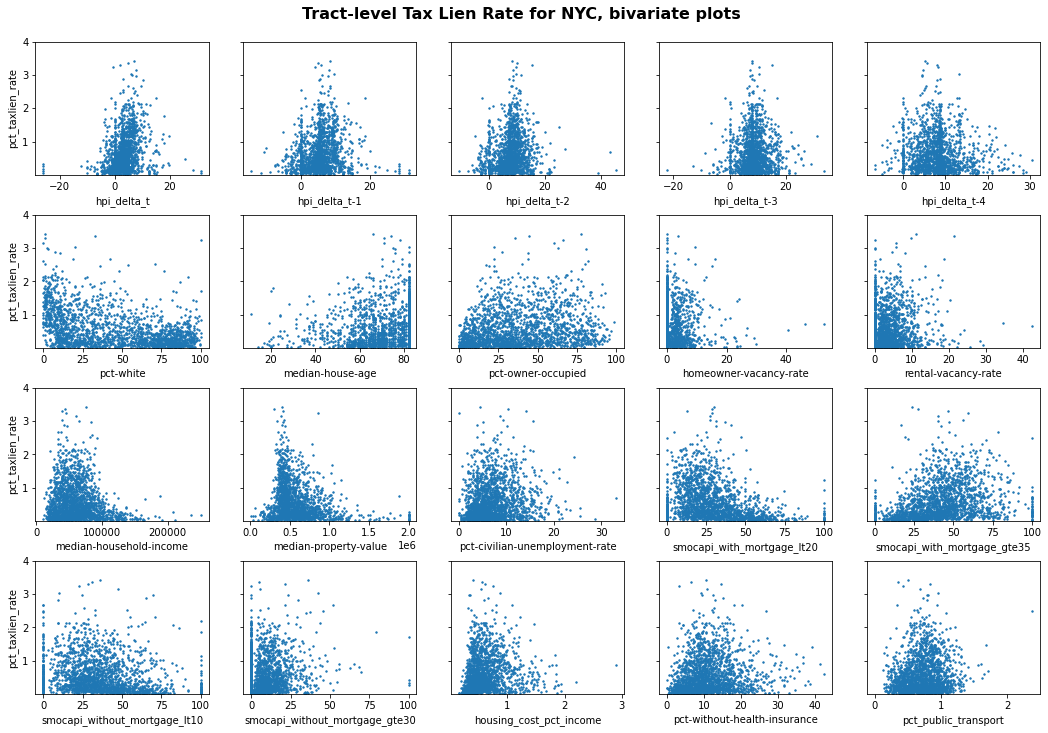

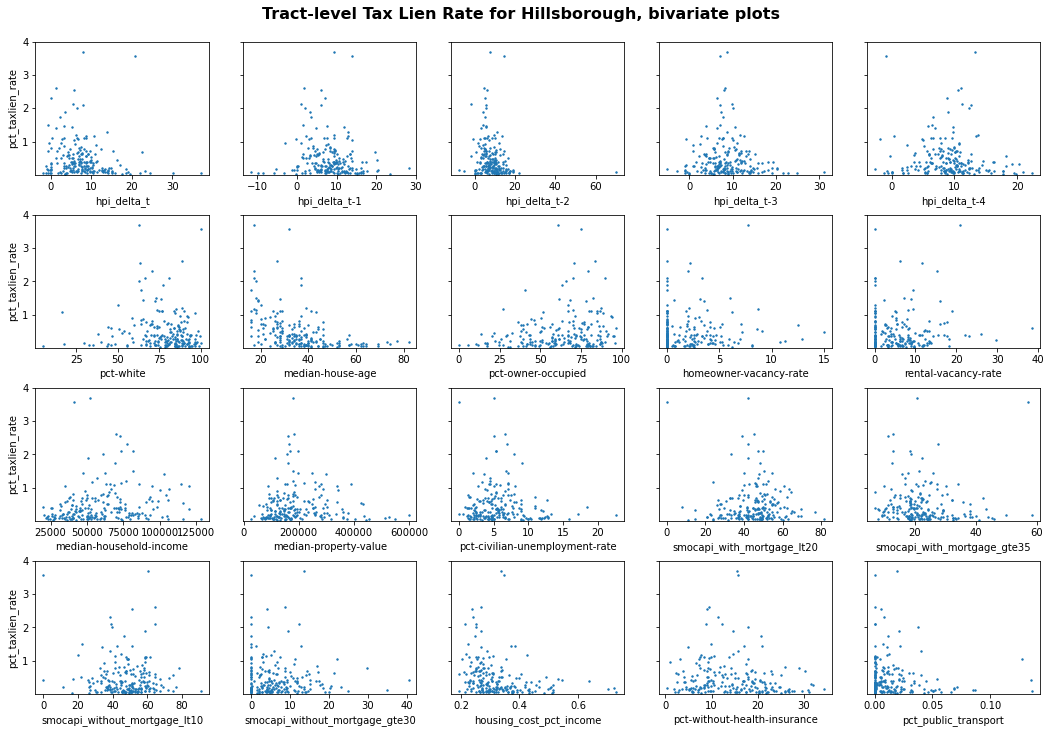

In [79]:
def plot_bivariate(region):
    """Plot bivariate plots (pct_taxlien_rate vs. potential predictors) for NYC or Hillsborough.
    
    Inputs
    ------
    region: Either 'NYC' or 'Hillsborough'
    
    Outputs
    -------
    None; this function simply plots and saves the figures 
    """
    
    if (region not in ['NYC', 'Hillsborough']):
        print('Region must be \'NYC\' or \'Hillsborough\'!')
        return None
    if (region == 'NYC'):
        input_df = nyc_all_merged
        savefig_name = 'nyc_pct_taxlien_rate_by_variables_v2.png'
    else:
        input_df = hillsborough_all_merged
        savefig_name = 'hillsborough_pct_taxlien_rate_by_variables_v2.png'
    
    fig, ax = plt.subplots(4, 5)
    fig.set_size_inches(18, 12)
    fig.subplots_adjust(wspace = 0.2, hspace = 0.3)
    fig.suptitle('Tract-level Tax Lien Rate for ' + region + ', bivariate plots', fontsize = 16, fontweight = 'bold', y = 0.92)

    ax_flat = ax.flatten()
    plot_vars = ['hpi_delta_t',
                 'hpi_delta_t-1',
                 'hpi_delta_t-2',
                 'hpi_delta_t-3',
                 'hpi_delta_t-4',
                 'pct-white',
                 'median-house-age',
                 'pct-owner-occupied',
                 'homeowner-vacancy-rate',
                 'rental-vacancy-rate',
                 'median-household-income',
                 'median-property-value',
                 'pct-civilian-unemployment-rate',
                 'smocapi_with_mortgage_lt20',
                 'smocapi_with_mortgage_gte35',
                 'smocapi_without_mortgage_lt10',
                 'smocapi_without_mortgage_gte30',
                 'housing_cost_pct_income',
                 'pct-without-health-insurance',
                 'pct_public_transport']
    for i in range(20):
        ax_flat[i].scatter(input_df[plot_vars[i]], input_df['pct_taxlien_rate'], s = 2)
        ax_flat[i].set_xlabel(plot_vars[i])
        ax_flat[i].set_ylim(0.01, 4.0)
        if (i % 5 > 0):
            ax_flat[i].set_yticklabels([])
        else:
            ax_flat[i].set_ylabel('pct_taxlien_rate')

    fig.savefig(savefig_name, dpi = 300)
    plt.show()
    
plot_bivariate('NYC')
plot_bivariate('Hillsborough')

<div class="alert alert-block alert-info" style="color:darkblue; font-size:14px">
    <strong>Observations</strong>:<br>
<ul>
    <li>There are a couple of census tracts in NYC where the lien rate is above 20%, and are thus clearly outliers; we will exclude these from modelling.</li>
    <li>It clearly appears that the trends in NYC and Hillsborough are markedly different (and Hillsborough bivariate plots show the opposite/counterintuitive trends in some cases), therefore is it extremely unlikely that a model fit on NYC data will generalize well to Hillsborough, and vice versa.</li>

In [102]:
def fit_OLS_models(input_df):
    """Fit Ordinary Least Squares (OLS) models to NYC data, and do a few rudimentary tests.
    
    Inputs
    ------
    input_df: The final dataframe containing the target variable and all potential predictors
    
    Outputs
    -------
    None for the moment, but could output the best predictor and test on Hillsborough data
    """

    # Remove outliers
    input_no_outliers = input_df[input_df['pct_taxlien_rate'] <= 4.0]

    # Use potential predictors, do variable selection manually
    predictors = ['hpi_delta_t',
                    'hpi_delta_t-1',
                    'hpi_delta_t-2',
                    #'hpi_delta_t-3',
                    #'hpi_delta_t-4',
                    'pct-white',
                    'pct_households_children',
                    'pct_older_adult_alone',
                    #'median-house-age',
                    'pct-owner-occupied',
                    'homeowner-vacancy-rate',
                    'rental-vacancy-rate',
                    'median-household-income',
                    'median-property-value',
                    'median-gross-rent',
                    #'pct-civilian-unemployment-rate',
                    'smocapi_with_mortgage_lt20',
                    #'smocapi_with_mortgage_gte35',
                    'smocapi_without_mortgage_lt10',
                    #'smocapi_without_mortgage_10_14.9',
                    'smocapi_without_mortgage_gte30',
                    #'housing_cost_pct_income',
                    'pct-without-health-insurance',
                    'pct_public_transport']
    model_variables = predictors + ['pct_taxlien_rate']
    # Create the modeling dataframe - keep only relevant variables and drop all observations with ANY missing values
    model_df = input_no_outliers[model_variables].dropna()
    test_df = hillsborough_all_merged[model_variables].dropna()
    print(model_df.info())
    print(model_df.isna().sum())
    print(test_df.info())

    # For the time being, we will just do an exploratory NYC model with no train-test split
    y_train = model_df['pct_taxlien_rate']
    X_train = model_df[predictors]
    y_test = test_df['pct_taxlien_rate']
    X_test = test_df[predictors]
    
    # First fit using Statsmodels, for a nice summary output
    print('OLS - Prediction of NYC tax lien rate')
    print('-------------------------------------')
    model = sm.OLS(y_train, sm.add_constant(X_train))
    results = model.fit()
    print(results.summary(), '\n')
    print('The Mean Squared Error (MSE) with this model is:', results.mse_resid)
    print('\n')

    # OLS with 10-fold cross-validation, using sklearn
    print('OLS, using sklearn with cross-validation')
    print('----------------------------------------')
    lm_ols_1 = LinearRegression(normalize = True)
    cross_val_metrics_1 = cross_validate(lm_ols_1, X_train, y_train, cv = 10,
                                           scoring = ['r2', 'neg_mean_squared_error'],
                                           return_estimator = True)

    # Look at cross-validated regression metrics
    for i, est in enumerate(cross_val_metrics_1['estimator']):
        print('Validation fold {0} has intercept {1:.4f}, coefficients [{2:s}],\
                  R^2 = {3:.3f}, MSE = {4:.3f}'\
                  .format(i + 1, est.intercept_, ', '.join(['{:.4f}'.format(x) for x in est.coef_]),
                          cross_val_metrics_1['test_r2'][i],
                          cross_val_metrics_1['test_neg_mean_squared_error'][i] * -1))
    
    # Manually select the best estimator to return
    best_estimator = cross_val_metrics_1['estimator'][6]
    
    # Predict on Hillsborough and see how good (or likely, bad!) this really is
    y_test_predicted = best_estimator.predict(X_test)
    # Change any negative observations in the prediction to zero
    y_test_predicted = y_test_predicted.clip(0)
    # Calculate the residuals, if we want to plot later
    residuals = pd.Series(y_test - y_test_predicted, index = y_test.index)
    # Calculate and print peformance metrics
    estimated_r2 = r2_score(y_test, y_test_predicted)
    test_MSE = mean_squared_error(y_test, y_test_predicted)
    print('\nThe best estimator (#7) on Hillsborough data has:\n\
    Estimated (adj.) R-squared = {0:.3f}\n\
    Estimated MSE = {1:.3f}'.format(estimated_r2, test_MSE))

    return best_estimator

best_estimator = fit_OLS_models(nyc_all_merged)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 0 to 1860
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hpi_delta_t                     1557 non-null   float64
 1   hpi_delta_t-1                   1557 non-null   float64
 2   hpi_delta_t-2                   1557 non-null   float64
 3   pct-white                       1557 non-null   float64
 4   pct_households_children         1557 non-null   float64
 5   pct_older_adult_alone           1557 non-null   float64
 6   pct-owner-occupied              1557 non-null   float64
 7   homeowner-vacancy-rate          1557 non-null   float64
 8   rental-vacancy-rate             1557 non-null   float64
 9   median-household-income         1557 non-null   float64
 10  median-property-value           1557 non-null   float64
 11  median-gross-rent               1557 non-null   float64
 12  smocapi_with_mortgage_lt20      15

<div class="alert alert-block alert-info" style="color:darkblue; font-size:14px">
    <strong>Observations</strong>:<br>
<ul>
    <li>OUCH! As we suspected from the bivariate plots, the model does not generalize at all to the Hillsborough data.</li>
    <li>Even for NYC though, it is pretty clear from the cross-validation metrics that there is a lot of sampling variation even across census tracts in the city, because the model metrics vary dramatically by cross-validation fold. In other words, the census tracts we choose to build the model make a very big difference in terms of its ability to generalize to other tracts within the city.</li>

<div class="alert alert-block alert-warning" style="color:brown; font-size:16px">
    <strong>CONCLUDING REMARKS</strong>:<br>
<ul>
    <li>Starting with the original question, namely whether a model can be build to predict tax liens at the property level, the short answer is: "No, not given the data at hand." Theoretically, this can be done if we obtain information about a large number of non-lien properties in the city as well, which will be cumbersome but is doable. However, it is definitely possible to roll up tax lien foreclosures to the census tract level and build a model on the tax lien foreclosure rate. That's exactly what this exercise attempted to do.</li>
    <li>Now, how good can a predictive model be? As this exercise shows, it can be serviceable given the data we have, and can likely be improved a fair bit by appending more data (e.g. unemployment for various years, other ACS data, AHS data, etc.) and then using various statistical techniques for feature engineering. <strong>BUT...</strong></li>
    <li>... The big open question remains <strong>"How generalizable a model can we build?"</strong> The maxim about all real estate being local due to the immovable nature of property will logically translate to studies of homelessness and evictions as well. As this rudimentary exercise shows, it is very difficult to build a generalizable model across extremely heterogeneous geographies like NYC and Hillsborough, and even within NYC itself, the model has A LOT of local variability.</li>
    <li>Finally, despite all that being said, there is certainly value to such exercises in terms of providing insight, even though they are possibly too slow and/or cumbersome for policy interventions. True AI approaches will likely allow throwing the (data) kitchen sink at such thorny problems at some point, but exercises such as these can point out exactly where to throw it!</li>